In [20]:
import monai
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchmetrics

In [2]:
# Generate synthetic 3D data
np.random.seed(42)

mask1 = monai.data.create_test_image_3d(height=32, width=256, depth=256, num_objs=100, rad_max=15)[0]
mask1[mask1 != 0] = 1

mask2 = monai.data.create_test_image_3d(height=32, width=256, depth=256, num_objs=100, rad_max=15)[0]
mask2[mask2 != 0] = 1

mask1 = torch.tensor(mask1)
mask2 = torch.tensor(mask2)

mask1.shape, mask2.shape

(torch.Size([32, 256, 256]), torch.Size([32, 256, 256]))

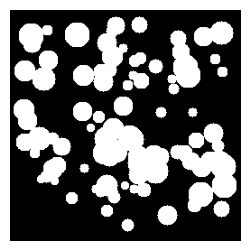

In [3]:
plt.figure(figsize=(3, 3))
plt.imshow(mask1[15, ...], cmap='gray')
plt.axis('off')
plt.show()

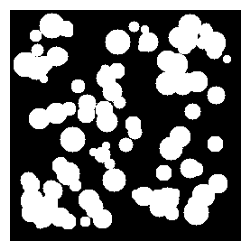

In [4]:
plt.figure(figsize=(3, 3))
plt.imshow(mask2[15, ...], cmap='gray')
plt.axis('off')
plt.show()

In [89]:
def simple_dice(a, b):
    intersection = torch.sum(a * b)
    union = torch.sum(a) + torch.sum(b)
    if union == 0:
        union = 1e-6
    dice = 2 * intersection / union
    
    return round(dice.item(), 4)

In [90]:
simple_dice(mask1, mask1), simple_dice(mask1, mask2)

(1.0, 0.3185)

In [91]:
dice_monai = monai.metrics.DiceMetric(include_background=False, num_classes=1)

In [17]:
dice_monai(
    y_pred = mask1[None, None, ...], # shape = [B, C, D, H, W], where B = batch dimension, C = class channels dimension
    y = mask1[None, None, ...]
)

tensor([[1.]])

In [92]:
dice_monai(
    y_pred = mask1[None, None, ...], # shape = [B, C, D, H, W]
    y = mask2[None, None, ...]
)

tensor([[0.3185]])

In [66]:
dice_torch = torchmetrics.Dice()

In [67]:
dice_torch(
    preds = mask1[None, None, ...],
    target = mask2[None, None, ...].type(torch.int8)
)

tensor(0.3185)

Batch

In [148]:
def create_synt_mask():
    '''Final shape = [B, D, H, W]
    '''
    mask = monai.data.create_test_image_3d(channel_dim=0, height=32, width=256, depth=256, num_objs=100, rad_max=15)[0]
    mask[mask != 0] = 1
    return torch.tensor(mask)

In [155]:
np.random.seed(54)
batch1 = torch.concatenate([create_synt_mask() for i in range(4)])
batch2 = torch.concatenate([create_synt_mask() for i in range(4)])

batch1.shape, batch2.shape

(torch.Size([4, 32, 256, 256]), torch.Size([4, 32, 256, 256]))

In [156]:
batch1.sum(), batch2.sum()

(tensor(1537798.), tensor(1497427.))

In [157]:
# Compute dice for entire batch as whole
simple_dice(batch1, batch1), simple_dice(batch1, batch2)

# (1.0, 0.3322)

(1.0, 0.3322)

In [158]:
# Compute dice separately per image
dices = []
for i in range(4):
    dice = simple_dice(batch1[i], batch1[i])
    dices.append(dice)
    
print(dices)
print(np.mean(dices))

dices = []
for i in range(4):
    dice = simple_dice(batch1[i], batch2[i])
    dices.append(dice)
    
print(dices)
print(round(np.mean(dices), 4))

# [1.0, 1.0, 1.0, 1.0]
# 1.0
# [0.3396, 0.3168, 0.3451, 0.3252]
# 0.3317

[1.0, 1.0, 1.0, 1.0]
1.0
[0.3396, 0.3168, 0.3451, 0.3252]
0.3317


Computing the dice for the entire batch as a whole and separately for each sample and then do the average lead to (a bit) different results. This corresponds to `torchmetrics.Dice`'s `average` parameter's arguments `'micro'` and `'samples'`.

In [159]:
dice_torch = torchmetrics.Dice(average='micro')
dice_torch(preds=batch1, target=batch1.type(torch.int8)), dice_torch(preds=batch1, target=batch2.type(torch.int8))

# (tensor(1.), tensor(0.3322))

(tensor(1.), tensor(0.3322))

In [160]:
dice_torch = torchmetrics.Dice(average='samples')
dice_torch(preds=batch1, target=batch1.type(torch.int8)), dice_torch(preds=batch1, target=batch2.type(torch.int8))

# (tensor(1.), tensor(0.3317))

(tensor(1.), tensor(0.3317))

In [162]:
# If I add a class dimension, the results are the same.
dice_torch = torchmetrics.Dice(average='micro')
print(dice_torch(preds=batch1[:, None, ...], target=batch1[:, None, ...].type(torch.int8)))
print(dice_torch(preds=batch1[:, None, ...], target=batch2[:, None, ...].type(torch.int8)))

tensor(1.)
tensor(0.3322)


In [163]:
dice_torch = torchmetrics.Dice(average='samples')
print(dice_torch(preds=batch1[:, None, ...], target=batch1[:, None, ...].type(torch.int8)))
print(dice_torch(preds=batch1[:, None, ...], target=batch2[:, None, ...].type(torch.int8)))

tensor(1.)
tensor(0.3317)


In [185]:
# Monai however always require the channel dimension
dice_monai = monai.metrics.DiceMetric(include_background=False, num_classes=1)

In [188]:
dice_monai(batch1[:, None, ...], batch1[:, None, ...])

tensor([[1.],
        [1.],
        [1.],
        [1.]])

In [189]:
dice_monai(batch1[:, None, ...], batch2[:, None, ...])

tensor([[0.3396],
        [0.3168],
        [0.3451],
        [0.3252]])

Monai retuns the metric per sample in the batch, then we have to apply compute the average to get a metric on the batch.

In [190]:
dice_monai(batch1[:, None, ...], batch2[:, None, ...]).mean()

tensor(0.3317)